<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/classica/clusterizacaoNoticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
import multiprocessing as mp
from sklearn.pipeline import make_pipeline
from google.colab import files, drive
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [3]:
#!rm news.*
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
#!unzip news.zip
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc/
!ls -lh 


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/nlp_tcc
total 1.2G
drwx------ 4 root root 4.0K Jul 31 20:13 amostra_news_integrada
-rw------- 1 root root 481M Jul 24 17:03 articles.csv
drwx------ 2 root root 4.0K Jul 31 17:49 bertimbau_base_results
drwx------ 2 root root 4.0K Jul 31 19:09 bertimbau_test
-rw------- 1 root root  93M Jul 24 15:58 news.csv
-rw------- 1 root root 521M Jul 25 22:30 news_integradas.csv
-rw------- 1 root root  93M Jul 24 15:42 noticia_tratada.csv


In [4]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [43]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams) 
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X)
  return [matriz_sparsa,count_vect]

def retornaMatriztfIdf(V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= TruncatedSVD(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int, sw=None):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10, stopwords = sw).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None, sw=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras, sw)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeCaracteresNaoDesejados(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeStopWords(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: aplicaStemming(x['text']),axis=1)

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1)):
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X,min_fr,max_fr,ngrams)
  V = vetores[0]
  return V
  

# Prepara dataset para clusterizacao

In [6]:
#dfDados = pd.read_csv('news_integradas.csv')
dfDados = pd.read_csv('./amostra_news_integrada/amostra_4/amostra.csv')
print(dfDados.shape)

(10000, 2)


In [57]:
#dfDados = dfDados.sample(frac=0.10)
#print(dfDados.shape)

(7129, 2)


In [6]:
dfDados.columns

Index(['text', 'category_nro'], dtype='object')

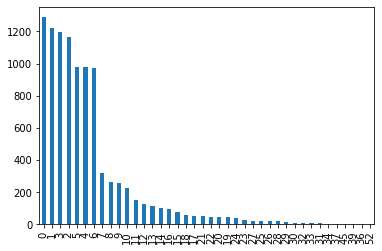

In [7]:
df = dfDados['category_nro'].value_counts()
df =df.head(40)
df.plot.bar()


In [10]:
#abrir arquivo news.csv
%%time

#dfDados = dfDados.sample(frac=0.2)

dfPreProc = PreProcessamentoParalelo(dfDados,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfDados.copy())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
CPU times: user 998 ms, sys: 427 ms, total: 1.43 s
Wall time: 2min 34s


In [11]:
print(dfPreProc.shape)
dfPreProc.head()

(10000, 2)


,text,category_nro
0,ano carr áre audit empr execu leonard potengy ...,2
1,cris econôm continu impact fort merc trabalh b...,2
2,presid eleit est unid donald trump minimiz nes...,4
3,log após proclam repúbl celebr nest quart abol...,1
4,oper lav jat sobr editor lul réu pergunt pesso...,10


In [12]:
dfPreProc.to_csv('./amostra_news_integrada/amostra_4/dfPreProc_25.csv')

In [65]:
V = processaVetorizacao(dfPreProc,min_fr=0.01, max_fr=0.7, ngrams=(1,2))
X_tfidf = retornaMatriztfIdf(V)

* https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2
* https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019


In [77]:
X = np.ones((X_tfidf.shape))
X_tfidf.toarray(out=X)
#a[:] = X_tfidf


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.07046857, 0.        ,
        0.04490656],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06173989, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

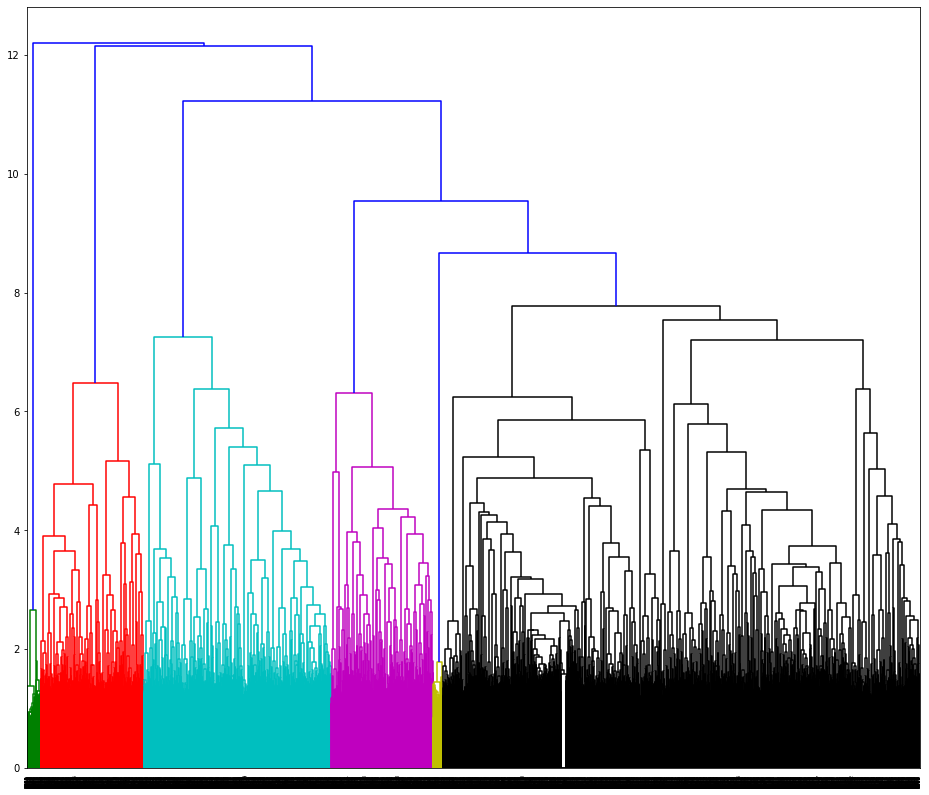

In [78]:
plt.figure(figsize=(16, 14))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.show()

In [82]:
model_6sets = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
model_10sets = AgglomerativeClustering(n_clusters=12, affinity='euclidean', linkage='ward')
model_15sets = AgglomerativeClustering(n_clusters=15, affinity='euclidean', linkage='ward')

In [88]:
dfDadosPred = dfDados.copy()
modelos = [model_15sets] #model_5sets, model_6sets, model_7sets
for i, model in enumerate(modelos):
  y_pred = model.fit_predict(X_tfidf.toarray())
  dfDadosPred['y_pred'+str(15)] = y_pred
  #print('model', i+5)
  print(dfDadosPred['y_pred15'].value_counts())

1     2226
0     2058
4     1356
6      998
10     683
9      654
2      474
3      423
5      321
14     218
7      152
13     145
12     113
11     102
8       77
Name: y_pred15, dtype: int64


In [89]:
dfDadosPred.columns

Index(['text', 'category_nro', 'y_pred', 'y_pred15'], dtype='object')

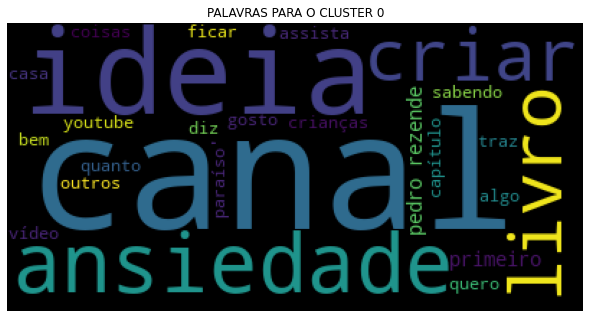

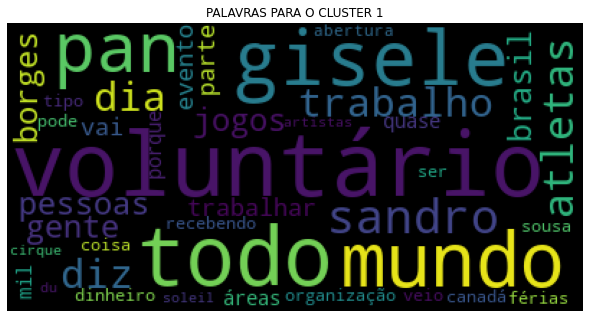

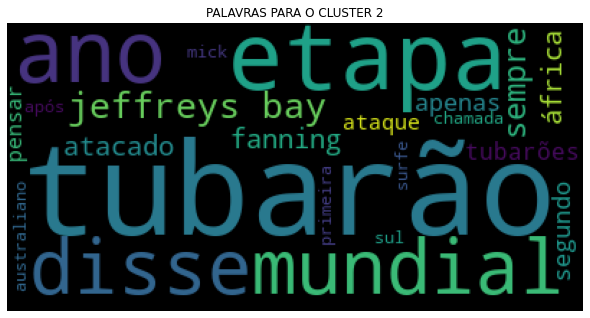

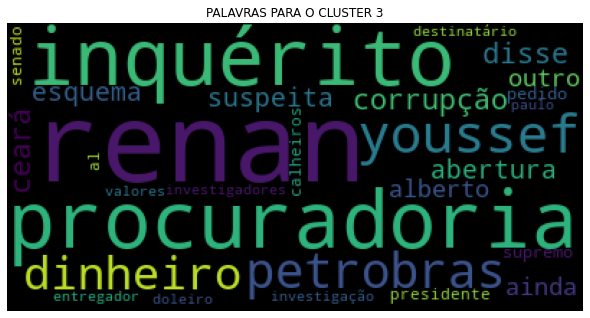

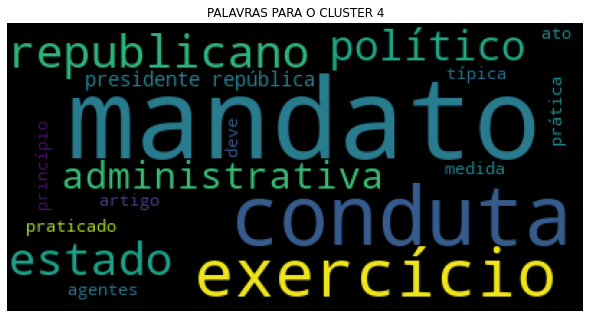

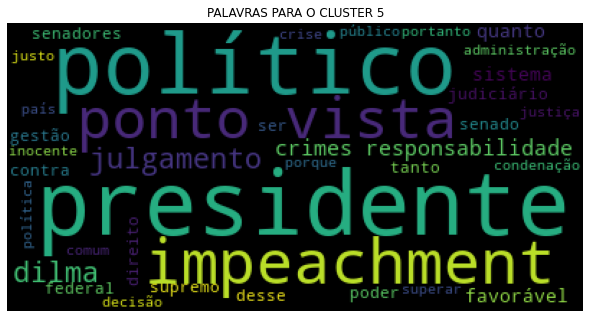

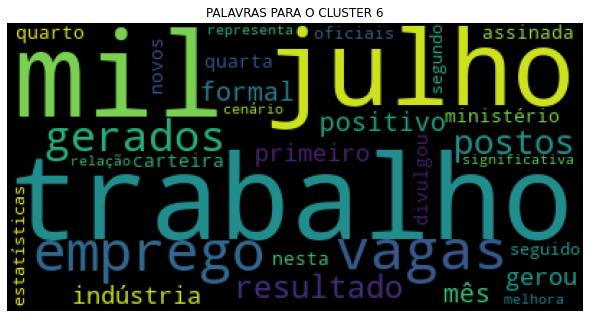

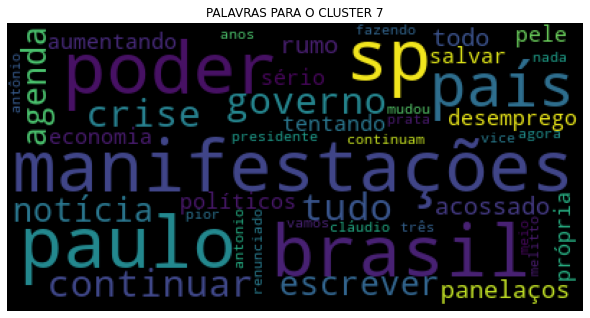

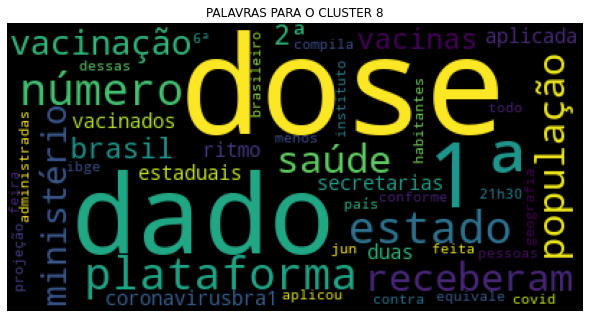

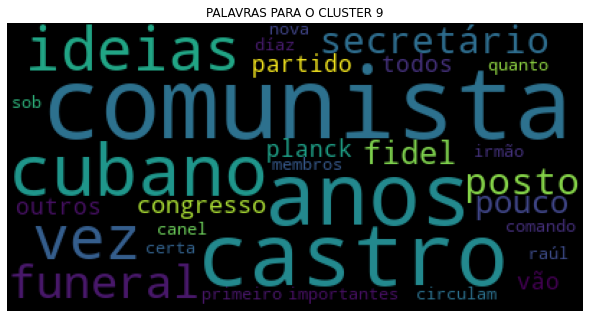

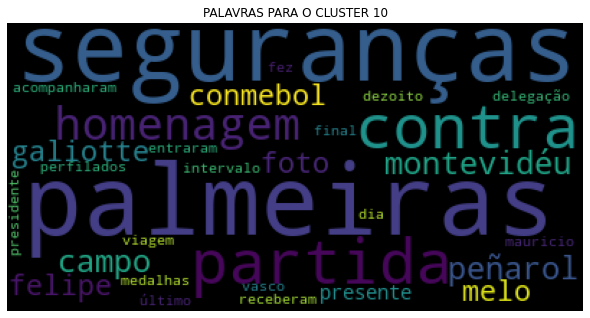

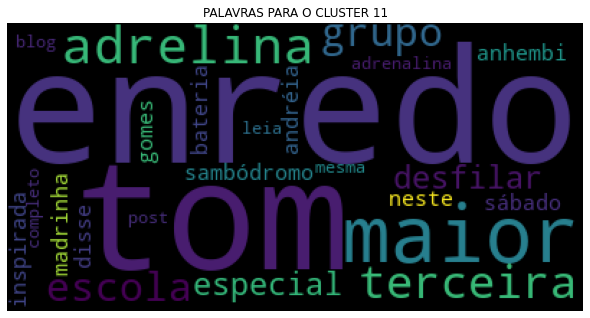

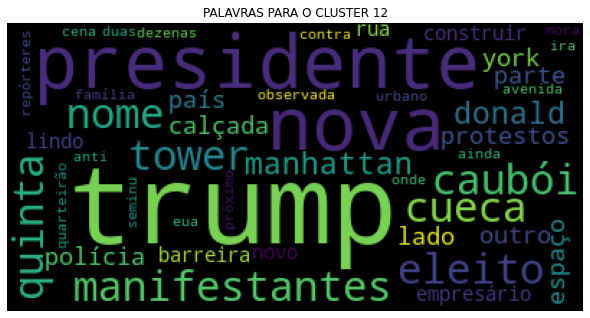

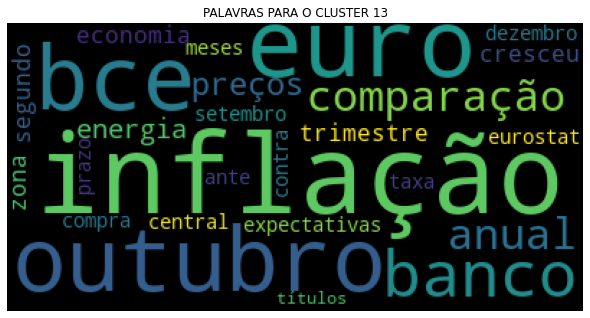

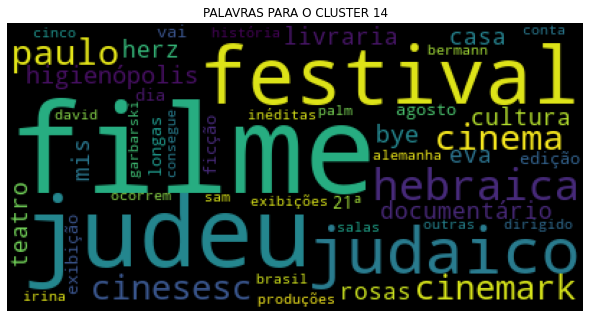

In [91]:
sw = nltk.corpus.stopwords.words('portuguese')
y_pred = 'y_pred15'
for y in np.sort(dfDadosPred[y_pred].unique()):
  dftmp = dfDados.loc[:,['text']][dfDadosPred[y_pred]==y]
  imprimiWordCloud(dftmp['text'].tolist(),100,str(y),sw)

In [64]:
for y in np.sort(dfDadosPred[y_pred].unique()):
  dftmp = dfDados.loc[:,['text']][dfDadosPred[y_pred]==y].head(10)
  print('**************** Cluster:', y ,'*****************')
  for t in dftmp['text'].tolist():
    print(t[0:256],'\n')
    print('------------------------------------------------')  
  print('*************************************************')

**************** Cluster: 0 *****************
Depois de 20 anos de carreira na área de auditoria de empresas, o executivo Leonardo Potengy, 42, foi demitido em outubro de 2014.  Durante um ano, tentou, sem sucesso, conseguir outro trabalho e acabou empurrado para o "empreendedorismo por necessidade".  

------------------------------------------------
O presidente eleito dos Estados Unidos, Donald Trump, minimizou nesta sexta-feira (13) as diferenças de opinião apresentadas por futuros integrantes de seu gabinete em relação às promessas feitas por ele durante a campanha eleitoral.  Nos últimos dias, fig 

------------------------------------------------
O trecho da marginal Tietê entre as pontes da Casa Verde e das Bandeiras foi o que mais registrou acidentes com mortes nos anos de 2013 e 2014.  No período, segundo dados oficiais da CET (Companhia de Engenharia de Tráfego), foram sete ocorrências desse ti 

------------------------------------------------
Ao menos 45 barracos foram des